In [147]:
import json
import statistics

import numpy as np

from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import EntropyHub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler

In [38]:
# some initial variables
ApEn_length = 2

In [39]:
with open("/Users/ruotsing/PycharmProjects/DMS/preprocess_data/SWA_data.json", "r") as f:
    SWA_data = json.load(f)

with open("/Users/ruotsing/PycharmProjects/DMS/preprocess_data/YA_data.json", "r") as f:
    YA_data = json.load(f)

with open("/Users/ruotsing/PycharmProjects/DMS/preprocess_data/ground_truth.json", "r") as f:
    ground_truth = json.load(f)
    
ground_truth = reform_ground_truth(ground_truth) # filter null ones
awake_window, light_drowsy_window, drowsy_window = ground_truth_sep(ground_truth, 10, ApEn_length) 
    

In [34]:
def extract_ApEn(data, m, length):
    #data is a dictionary
    #length is the window size [sec]
    sample_rate = 100
    ApEn = {}
    for name in data.keys():
        ApEn[name] = []
        for i in range(0,len(data[name])//sample_rate-length, length):
            sig=data[name][i*sample_rate:(i+length)*sample_rate]
            Ap,Phi=EntropyHub.ApEn(sig,m,1,0.2*np.std(sig))
            ApEn[name].append(Ap[m])
    
    return ApEn   

In [40]:
SWA_ApEn = extract_ApEn(SWA_data, 2, ApEn_length)
YA_ApEn = extract_ApEn(YA_data, 2, ApEn_length)

In [72]:
def define_feature_matrix(label_window, SWA_ApEn,YA_ApEn, ApEn_length):
    feature_matrix = []
    for name in label_window.keys():
        for i in range(len(label_window[name])):
            begin=int(label_window[name][i][0]/ApEn_length)
            end=int(label_window[name][i][-1*ApEn_length]/ApEn_length)+1
            SWA_feature=SWA_ApEn[name][begin:end]
            YA_feature=YA_ApEn[name][begin:end]
            if len(SWA_feature)!=5 or len(YA_feature)!=5:
                break
            feature_matrix.append([SWA_feature,YA_feature])
    return np.array(feature_matrix)     

In [73]:
awake_feature_matrix = define_feature_matrix(awake_window, SWA_ApEn,YA_ApEn, ApEn_length)
awake_label = np.ones(len(awake_feature_matrix))
light_drowsy_feature_matrix = define_feature_matrix(light_drowsy_window, SWA_ApEn,YA_ApEn, ApEn_length)
light_drowsy_label = np.ones(len(light_drowsy_feature_matrix))*2
drowsy_feature_matrix = define_feature_matrix(drowsy_window, SWA_ApEn,YA_ApEn, ApEn_length)
drowsy_label = np.ones(len(drowsy_feature_matrix))*3

In [74]:
feature_matrix=np.row_stack((awake_feature_matrix,light_drowsy_feature_matrix,drowsy_feature_matrix))
label=np.concatenate((awake_label,light_drowsy_label,drowsy_label))

In [149]:
# Split the data into training, validation and testing
X_train, X_test, y_train, y_test_cm = train_test_split(feature_matrix, label, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train - 1, 3)
y_test = tf.keras.utils.to_categorical(y_test_cm - 1, 3)
y_val = tf.keras.utils.to_categorical(y_val - 1, 3)

In [143]:
 # Neural Network
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,5)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(21, activation='tanh'),
    tf.keras.layers.Dense(21, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.082, momentum=0.95), 
              loss='crossentropy', 
              metrics=['FalseNegatives', 'FalsePositives'])

In [144]:

model.fit(X_train, y_train, epochs=20)

Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - FalseNegatives: 1260.7355 - FalsePositives: 1201.8967 - loss: 0.6636
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - FalseNegatives: 1170.1838 - FalsePositives: 1170.1838 - loss: 0.6166
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - FalseNegatives: 1196.8904 - FalsePositives: 1195.1129 - loss: 0.6241
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - FalseNegatives: 1176.7032 - FalsePositives: 1176.7032 - loss: 0.6090
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - FalseNegatives: 1176.0903 - FalsePositives: 1176.0903 - loss: 0.6037
Epoch 6/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - FalseNegatives: 1195.8904 - FalsePositives: 1194.9613 - loss: 0.6137
Epoch 7/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - FalseNegatives: 1176.4517 - FalsePositives: 1174.5420 - loss: 0.6035
Epoch 8/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - FalseNegatives: 1155.1194 - FalsePositives: 1155.1194 - loss: 0.5937


In [145]:
test_loss, FN, FP = model.evaluate(X_test,  y_test, verbose=2)

78/78 - 0s - 1ms/step - FalseNegatives: 556.0000 - FalsePositives: 556.0000 - loss: 0.6117


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


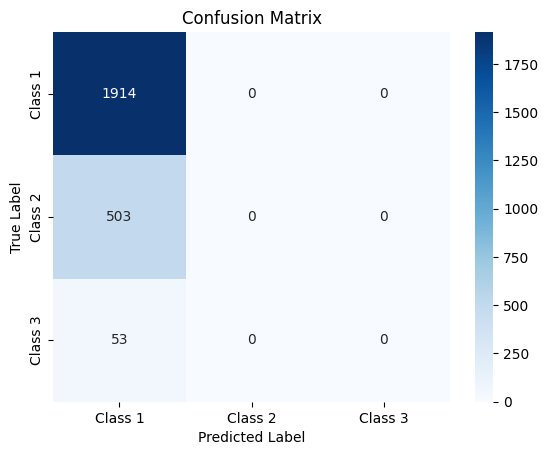

In [146]:

y_pred=[]
for row in model.predict(X_test):
    y_pred.append(np.argmax(row)+1)
y_pred=np.array(y_pred)    
cm = confusion_matrix(y_test_cm, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [140]:
# Hyperparameter tuning
def model_builder(hp):
  model = tf.keras.Sequential([tf.keras.layers.Input(shape=(2,5)),
    tf.keras.layers.Flatten()])
  
  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value=3, max_value=30, step=1)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='tanh'))
  model.add(tf.keras.layers.Dense(units=hp_units, activation='tanh'))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['FalseNegatives', 'FalsePositives'])
  return model

In [141]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=200,
                     factor=3,
                     directory='neural_network',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[stop_early])

Trial 78 Complete [00h 00m 01s]
val_loss: 0.6761900782585144

Best val_loss So Far: 0.6077954173088074
Total elapsed time: 00h 04m 48s


In [142]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 21 and the optimal learning rate for the optimizer
is 0.01.



In [150]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 10)).reshape(-1, 2, 5)
X_val = scaler.transform(X_val.reshape(-1, 10)).reshape(-1, 2, 5)
X_test = scaler.transform(X_test.reshape(-1, 10)).reshape(-1, 2, 5)

X_train=np.clip(X_train, -5, 5)
X_val=np.clip(X_val, -5, 5)
X_test=np.clip(X_test, -5, 5)


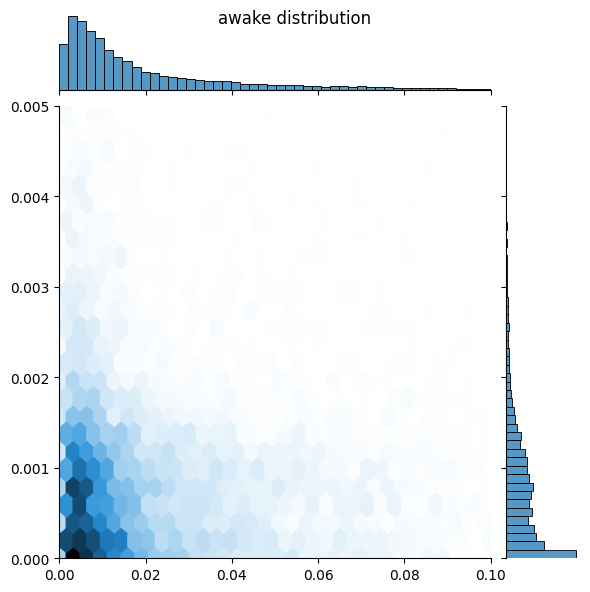

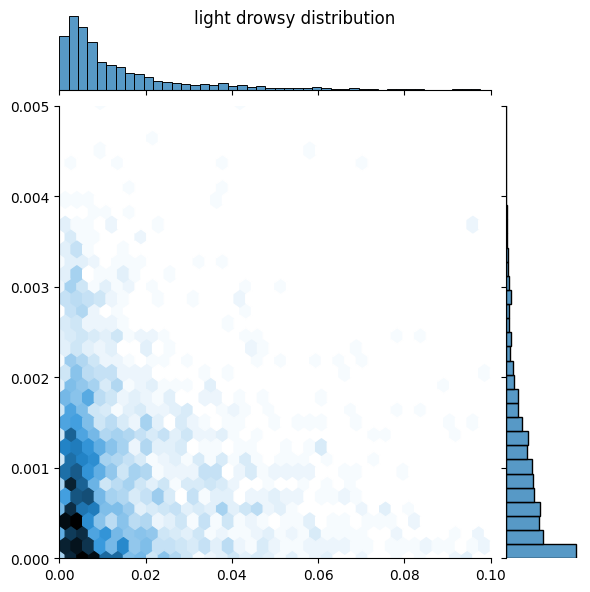

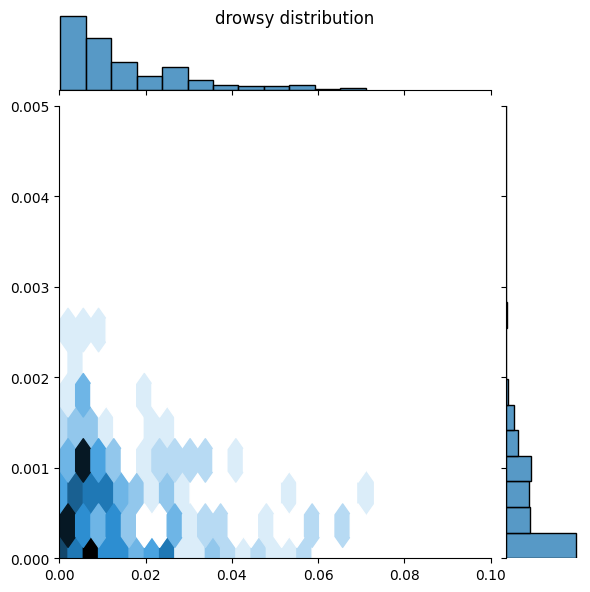

In [157]:
#visualize the data distribution
SWA_ApEn_var_awake=[]
YA_ApEn_var_awake=[]
SWA_ApEn_var_light_drowsy=[]
YA_ApEn_var_light_drowsy=[]
SWA_ApEn_var_drowsy=[]
YA_ApEn_var_drowsy=[]
for row in awake_feature_matrix:
    SWA_ApEn_var_awake.append(np.var(row[0]))
    YA_ApEn_var_awake.append(np.var(row[1])
    )
    
for row in light_drowsy_feature_matrix:
    SWA_ApEn_var_light_drowsy.append(np.var(row[0]))
    YA_ApEn_var_light_drowsy.append(np.var(row[1]))
    
    
for row in drowsy_feature_matrix:
    SWA_ApEn_var_drowsy.append(np.var(row[0]))
    YA_ApEn_var_drowsy.append(np.var(row[1]))
    
sns.jointplot(x=SWA_ApEn_var_awake, y=YA_ApEn_var_awake,
              kind='hex', xlim=(0,0.1), ylim=(0,0.005))
plt.suptitle("awake distribution")

sns.jointplot(x=SWA_ApEn_var_light_drowsy, y=YA_ApEn_var_light_drowsy,
              kind='hex', xlim=(0,0.1), ylim=(0,0.005))
_ = plt.suptitle("light drowsy distribution")

sns.jointplot(x=SWA_ApEn_var_drowsy, y=YA_ApEn_var_drowsy,
              kind='hex', xlim=(0,0.1), ylim=(0,0.005))
_ = plt.suptitle("drowsy distribution")